In [1]:
import numpy as np
import matplotlib.pyplot as plt
from train import get_parser
from ssd.config.defaults import cfg
from ssd.data.build import make_data_loader
from vizer.draw import draw_boxes
%matplotlib inline
from matplotlib import pyplot as plt

import cv2
from urllib.request import urlopen
from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)
np.random.seed(0)
#test the new aug. From the paper about data augmentation
#from ssd.data.transforms.autoaugment_utils import *

/home/xyzhu/anaconda3/envs/tdt4265/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xyzhu/anaconda3/envs/tdt4265/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xyzhu/anaconda3/envs/tdt4265/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xyzhu/anaconda3/env

In [2]:
config_path = "configs/train_waymo_Copy1.yaml"
cfg.merge_from_file(config_path)
cfg.freeze()

In [3]:
from ssd.data.transforms.transforms import *
from torchvision import transforms

In [4]:
#Dive into the data loading
import pathlib
from PIL import Image
import json

def _read_image(index):
    data_dir = "datasets/waymo"
    data_dir =pathlib.Path(data_dir)
    image_id = index
    image_path = data_dir.joinpath("images").joinpath(f"{image_id}.jpg")
    image = Image.open(str(image_path)).convert("RGB")
    image = np.array(image)
    return image
def _get_annotation(image_id,labels):
    label = labels[image_id]
    bbox_key = "bounding_boxes"
    if bbox_key not in label:
        bbox_key = "bboxes"
    boxes = np.zeros((len(label[bbox_key]), 4), dtype=np.float32)
    labels = np.zeros((len(label[bbox_key])), dtype=np.int64)
    for idx, bounding_box in enumerate(label[bbox_key]):
        box = [
            bounding_box["xmin"],
            bounding_box["ymin"],
            bounding_box["xmax"],
            bounding_box["ymax"]]
        boxes[idx] = box
        labels[idx] = bounding_box["label_id"]
    # SSD use label 0 as the background. Therefore +1
    labels = labels + 1
    return boxes, labels
def read_labels(label_path):
    assert label_path.is_file(), \
        f"Did not find label file: {label_path.absolute()}"
    with open(label_path, "r") as fp:
        labels = json.load(fp)
    labels_processed = {}
    for label in labels:
        image_id = label["image_id"]
        labels_processed[image_id] = label
    return labels_processed

In [5]:
#get the image '1.jpg' and relating box and label
idx = 1
print(idx)
image_test=_read_image(idx)
data_dir = "datasets/waymo"
data_dir =pathlib.Path(data_dir)
label_total=read_labels(data_dir.joinpath("labels.json"))
label_test=_get_annotation(idx,label_total)
box_test=label_test[0] 
label_test = label_test[1]
class_test='__background__', 'vehicle', 'person', 'sign', 'cyclist'

1


In [6]:
#print('image_test',image_test.shape)
#print('label_test',label_test)
#print('box_test',box_test)

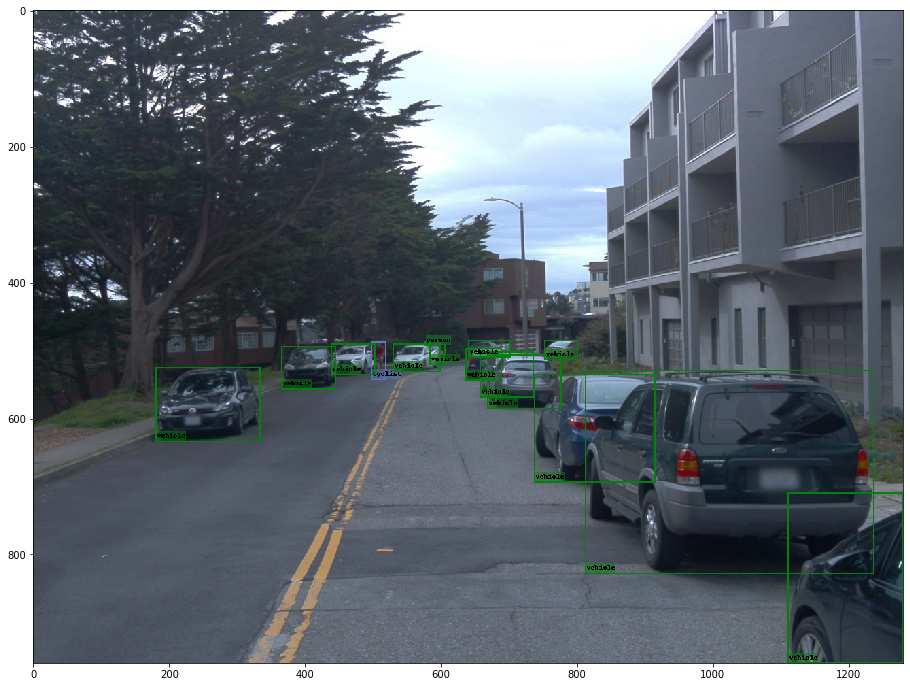

In [7]:
#Show the original version of the '1.jpg'
image_show = draw_boxes(
    image_test, box_test, label_test, class_name_map=class_test)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [8]:
#For the paper about data augmentation
#This is the data augmentation used in Xiaoyu's code
t1=ConvertFromInts()
t2=colorJitter()
t3=RandomErasing()
#t2=PhotometricDistort()
t4=Expand(cfg.INPUT.PIXEL_MEAN)
t5=RandomSampleCrop()
t6=RandomMirror()
t7=ToPercentCoords()
t8=Resize(cfg.INPUT.IMAGE_SIZE)
t9=SubtractMeans(cfg.INPUT.PIXEL_MEAN)
t10=ToPILImage()
t_absolute_coor=ToAbsoluteCoords()
trans_pol=DataAaugmentationPolicy('test')
to_tensor = ToTensor()

In [9]:
img,box,label=t7(image_test,box_test,label_test)

In [10]:
img,box,label=trans_pol(img,box,label)

image [[[122 125 158]
  [201 205 232]
  [217 222 241]
  ...
  [104 111 130]
  [105 110 130]
  [103 108 128]]

 [[ 81  84 117]
  [118 122 149]
  [185 190 209]
  ...
  [104 111 130]
  [103 108 128]
  [102 107 127]]

 [[ 70  73 108]
  [ 75  79 108]
  [ 81  86 105]
  ...
  [103 109 131]
  [102 107 129]
  [101 106 128]]

 ...

 [[ 79  87 100]
  [ 79  87 100]
  [ 78  86  99]
  ...
  [ 44  54  66]
  [ 44  52  65]
  [ 43  51  64]]

 [[ 80  88 101]
  [ 80  88 101]
  [ 79  87 100]
  ...
  [ 45  54  69]
  [ 44  53  68]
  [ 43  52  67]]

 [[ 79  87 100]
  [ 79  87 100]
  [ 78  86  99]
  ...
  [ 44  53  68]
  [ 43  52  67]
  [ 42  51  66]]] boxes [[0.45048076 0.50625885 0.45569435 0.5141537 ]
 [0.5139749  0.52303547 0.57542086 0.59310246]
 [0.49721688 0.51785445 0.5385533  0.56769085]
 [0.38829    0.5074924  0.40616518 0.56621057]
 [0.5219815  0.5279698  0.6076335  0.61086595]
 [0.8673822  0.7389109  1.         1.        ]
 [0.57579327 0.558069   0.7154432  0.7238614 ]
 [0.3422986  0.51119316 0.393

In [ ]:
#Rotate with bboxes
def rotate(image, degrees, replace):
    # Convert from degrees to radians.
    degrees_to_radians = math.pi / 180.0
    radians = degrees * degrees_to_radians
    print('degrees',degrees)
    print('radians',radians)
    if image.shape[0] == 0 or image.shape[1] == 0:
      return image

    if isinstance(image, np.ndarray):
        img = Image.fromarray(np.uint8(image))
    
    rot = img.convert("RGBA").rotate(degrees)
    print('rot',rot.size)
    print('replace',replace[0])
    img = Image.composite(rot, Image.new("RGBA", rot.size, (replace[0],) * 4), rot).convert(img.mode)

    return np.array(img)



def rotate_with_bboxes(image, bboxes, degrees, replace):
  """Equivalent of PIL Rotate that rotates the image and bbox.
  Args:
    image: 3D uint8 Tensor.
    bboxes: 2D Tensor that is a list of the bboxes in the image. Each bbox
      has 4 elements (min_y, min_x, max_y, max_x) of type float.
    degrees: Float, a scalar angle in degrees to rotate all images by. If
      degrees is positive the image will be rotated clockwise otherwise it will
      be rotated counterclockwise.
    replace: A one or three value 1D tensor to fill empty pixels.
  Returns:
    A tuple containing a 3D uint8 Tensor that will be the result of rotating
    image by degrees. The second element of the tuple is bboxes, where now
    the coordinates will be shifted to reflect the rotated image.
  """
  # Rotate the image.
  image = rotate(image, degrees, replace)

  # Convert bbox coordinates to pixel values.
  image_height = image.shape[0]
  image_width = image.shape[1]
  # pylint:disable=g-long-lambda
  wrapped_rotate_bbox = lambda bbox: _rotate_bbox(
      bbox, image_height, image_width, degrees)
  # pylint:enable=g-long-lambda
  bboxes = np.array([box for box in list(map(wrapped_rotate_bbox, bboxes)) if box is not None])

  return image.astype(np.uint8), bboxes

In [ ]:
img,box = rotate_with_bboxes(img.astype(np.float32),box,0.6,10)

In [ ]:
img,box,label=t1(image_test,box_test,label_test)

In [ ]:
img,box,label=t7(img,box,label)

In [ ]:
img,box,label=trans_pol(image_test,box_test,label_test)

In [ ]:
img,box,label=t8(img,box,label)

In [ ]:
#Convert_to_absolute_corrdinate_for_plot
img,box,label=t_absolute_coor(img,box,label)

In [ ]:
image_show = draw_boxes(
    img.astype('uint8'), box, label_test, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)